In [1]:
import numpy as np
import arviz as az 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import stan
from os.path import exists
import pickle
import os
import json
from multiprocessing import Pool
!pip install multiprocess
import pickle 
%matplotlib inline
import glob
import itertools
import nest_asyncio
import time
import string
nest_asyncio.apply()

from src.model import *
from src.util import *
from src.plotting import *




<h1> Setup</h1>

In [4]:
##Set names of your dependent variable, 
##Binary indicator of pre-post,
##Window on either side of the discontinuity (must be symmetric), 
## and User ID column
outcome = 'non_covid'
indicator = 'SU_banned'
window = 30

user_column = 'user_id'

#Make some output directories
make_dir = lambda fname: os.makedirs(fname) if not os.path.exists(fname) else None
make_dir('output')
make_dir('output/posteriors/')
make_dir('output/figures')
make_dir('output/figures/main')
make_dir('output/figures/evaluation')


#Load model code
with open('./src/model.stan', 'r') as file:
    model_code = file.read() 


<h1>Data Processing</h1>

In [5]:

#Load data
all_timeseries = pd.read_csv('./dat/all_reliable_amplifier_activity_counts_10_20_22.csv')
super_user_names = all_timeseries['suspended_user'].unique()


#Get a list of all the follower for a given removed user
get_users = lambda x: all_timeseries[(all_timeseries['group']==x[0]) & (all_timeseries['suspended_user']==x[1])]['user_id'].unique()

#A function to make a dataframe for for followers relevant to each condition. 
def make_condition_df(condition):
    users = get_users(condition)
    df = pd.DataFrame({'users':users})
    df['group'] = condition[0]
    df['suspended_user'] = condition[1]
    
    df1 = df.copy()
    df2 = df.copy()
    df1['outcome'] = 'non_covid_tweets'
    df2['outcome'] = 'covid_tweets'
    
    df = pd.concat([df1,df2])
    df['posterior_location'] = './output/posteriors/'+df['outcome'] + '_' + df['suspended_user'] + '_' + df['users'].astype(str) + '.json'
    df['completed'] = False
    
    return df


#Create a list of all unique conditions
all_conditions = list(itertools.product(['median','top'],super_user_names))

#Create a dataframe for each condition, use this to construct a df tracking files to process 
processing_df = pd.concat([make_condition_df(condition) for condition in all_conditions])
processing_df.to_csv('./output/processing_df.csv',index=False)


#Create a directory to store data for each follower 
make_dir('./output/split_data/')

#This function splits the data by follower and saves it to a unique csv 
split_row = lambda row: all_timeseries[(all_timeseries['group']==row['group']) & 
               (all_timeseries['suspended_user']==row['suspended_user']) & 
               (all_timeseries['user_id']==row['users'])].to_csv('./output/split_data/'+row['suspended_user']+'_'+str(row['users'])+'.csv',index=False)

#Apply splitting to the entire dataset  
processing_df.apply(split_row,axis=1)

#Add the location of the split data file to the processing df
processing_df['raw_data_file'] = './output/split_data/'+processing_df['suspended_user']+'_'+processing_df['users'].astype(str)+'.csv'

processing_df

,users,group,suspended_user,outcome,posterior_location,completed,raw_data_file
0,1038842391241867265,median,AlexBerenson,non_covid_tweets,./output/posteriors/non_covid_tweets_AlexBeren...,False,./output/split_data/AlexBerenson_1038842391241...
1,1058364568177647616,median,AlexBerenson,non_covid_tweets,./output/posteriors/non_covid_tweets_AlexBeren...,False,./output/split_data/AlexBerenson_1058364568177...
2,1117424294370402307,median,AlexBerenson,non_covid_tweets,./output/posteriors/non_covid_tweets_AlexBeren...,False,./output/split_data/AlexBerenson_1117424294370...
3,1128822301737275397,median,AlexBerenson,non_covid_tweets,./output/posteriors/non_covid_tweets_AlexBeren...,False,./output/split_data/AlexBerenson_1128822301737...
4,1133731222709055488,median,AlexBerenson,non_covid_tweets,./output/posteriors/non_covid_tweets_AlexBeren...,False,./output/split_data/AlexBerenson_1133731222709...
...,...,...,...,...,...,...,...
45,888135405446365184,top,RWMaloneMD,covid_tweets,./output/posteriors/covid_tweets_RWMaloneMD_88...,False,./output/split_data/RWMaloneMD_888135405446365...
46,948162149066657792,top,RWMaloneMD,covid_tweets,./output/posteriors/covid_tweets_RWMaloneMD_94...,False,./output/split_data/RWMaloneMD_948162149066657...
47,949407894394556417,top,RWMaloneMD,covid_tweets,./output/posteriors/covid_tweets_RWMaloneMD_94...,False,./output/split_data/RWMaloneMD_949407894394556...
48,952539957096210434,top,RWMaloneMD,covid_tweets,./output/posteriors/covid_tweets_RWMaloneMD_95...,False,./output/split_data/RWMaloneMD_952539957096210...


<h2>Run the model</h2>

In [7]:
import os.path
processing_df['completed'] = processing_df['posterior_location'].apply(lambda x: os.path.exists(x))
print(processing_df['completed'].mean() )

1.0


In [ ]:
import logging
logger = logging.getLogger('pystan')
logger.addHandler(logging.NullHandler())

with open('./src/model.stan', 'r') as file:
    model_code = file.read() 



#open model code
with open('./src/model.stan', 'r') as file:
    model_code = file.read() 


for row in processing_df.iterrows():
    completed = process_row(row[1], model_code,  window=30)
    if completed:
        processing_df.loc[row[0],'completed'] = True
        processing_df.to_csv('./output/processing_df.csv',index=False)
print(sum(processing_df['completed']))
print(glob.glob('./output/posteriors/*').__len__())

In [ ]:
print(sum(processing_df['completed']))
print(glob.glob('./output/posteriors/*').__len__())

<h1>Figure 1</h1> 

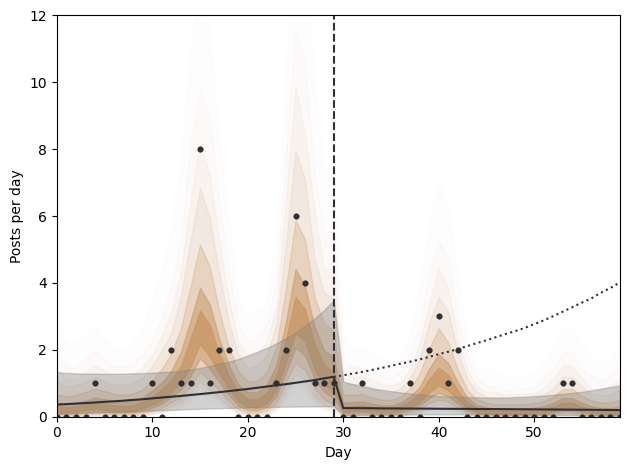

In [10]:
posteriors = glob.glob('./output/posteriors/*')

def plot_posterior_predictive( posteriors, id,axs, window=30):
    idata = az.from_json(posteriors[id])

    plt.scatter(np.arange(window*2), idata.observed_data.y,color=np.array([47,47,56])/255,zorder=2,s=10)


    #We can extract it (it's in log scale, so we take an exp)
    #It is a matrix of 4000 x window*2, containing samples from the posterior predictive distribution
    exp_post = np.exp(idata.posterior_predictive.exp_hat)

        
    #Our idata object has actual data, let's plot that
    #Stored as seen below
    plt.scatter(np.arange(window*2), idata.observed_data.y,color=np.array([47,47,56])/255,zorder=2,s=10)

    #And plot various credible intervals, perhaps with shading.
    for q in (1,3,6,11, 25,50,75):
        cis = np.nanpercentile(np.array(exp_post).reshape(4000,window*2), q=[0+q/2, 100-q/2],axis=0)
        plt.fill_between(np.arange(window*2), cis[0], cis[1], alpha = q/100,color= orange)

    #exp_hat contains the mean function
    ci = np.nanpercentile(np.exp(np.array(idata.posterior_predictive.mu_hat)).reshape(4000,window*2),
                    axis=0,
                    q=[5.5,50, 94.5])

    #Plot the 94\% credible interval as being shaded
    plt.fill_between(np.arange(window*2), ci[0], ci[2], alpha=.35, color='grey')
    
    #Plot the median as a line
    plt.plot(np.arange(window*2), ci[1], color=np.array([47,47,56])/255)
    
    
    #exp_hat contains the mean function
    ci = np.nanpercentile(np.exp(np.array(idata.posterior_predictive.mu_hat_without_ban)).reshape(4000,window*2),
                    axis=0,
                    q=[5.5,50, 94.5])

    #Plot the 94\% credible interval as being shaded
    # plt.fill_between(np.arange(window*2)[29:], ci[0][29:], ci[2][29:], alpha=.35, color='powderblue')
    
    #Plot the median as a line
    plt.plot(np.arange(window*2)[29:], ci[1][29:], color=np.array([47,47,56])/255, ls=':')
    

    #Clean things up
    plt.ylabel('Posts per day')
    plt.xlabel('Day')
    plt.ylim(0,np.max(idata.observed_data.y)*1.5)
    plt.xlim(0,window*2-1)
    plt.plot([window-1,window-1],
                [0, 4000],
                color=np.array([47,47,56])/255,
                ls='--')
    plt.tight_layout()

    plt.savefig('./output/figures/fig1.png',dpi=300)

plot_posterior_predictive(posteriors, 100, plt.gca(), window=30)

<h1> Plotting Posteriors for all users</h1>

In [ ]:
#Plot in parallel, so this doesn't take forever. 
make_dir('./output/figures/posteriors/')
import multiprocess as mp
if __name__ ==  '__main__': 
    pool = mp.Pool()
    results =  pool.map(plot_posterior_and_change, glob.glob('./output/posteriors/*'))
    pool.close()
    pool.join()


<h1>Aggregate across fits</h1>

In [11]:
idata = az.from_json(processing_df['posterior_location'].iloc[0])
idata.observed_data['timestep']

<xarray.DataArray 'timestep' (timestep: 60)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59])
Coordinates:
  * timestep  (timestep) int64 0 1 2 3 4 5 6 7 8 ... 51 52 53 54 55 56 57 58 59

In [12]:
#Gather median change by group, outcome, and suspended user
from src.util import get_median_change
import multiprocess as mp
grouped =  processing_df.groupby(['group', 'outcome', 'suspended_user'])
if __name__ ==  '__main__': 
    pool = mp.Pool()
    results =  pool.map(get_median_change, grouped) 
    pool.close()
    pool.join()


In [13]:
#Gather median change by group, outcome, and suspended user
group_flattened = grouped.count().reset_index()
group_flattened['results'] = results

<h1>Figure 2</h1>

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


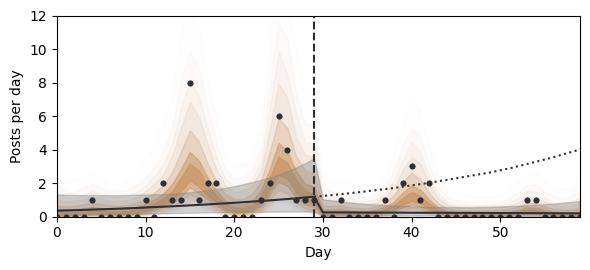

In [36]:
%load_ext autoreload
%autoreload 2
from src.plotting import plot_change_by_group
fig, axs = plt.subplots(1,1, figsize=(6,14/5))

grouped = group_flattened.groupby(['group','outcome'])


groups = []
plt.sca(axs)
plot_posterior_predictive(posteriors, 100, plt.gca(), window=30)
plt.savefig('./output/figures/fig1.png', dpi=300)
plt.savefig('./output/figures/fig1.pdf')



In [ ]:
%load_ext autoreload
%autoreload 2
from src.plotting import plot_change_by_group
fig, axs = plt.subplots(4,1, figsize=(6,14 - 14/5))

grouped = group_flattened.groupby(['group','outcome'])


groups = []
# plt.sca(axs[0])
# plot_posterior_predictive(posteriors, 100, plt.gca(), window=30)


plt.sca(axs[0])
group = grouped.get_group(('top','non_covid_tweets'))
plt.title('Highly engaged followers: non-Covid posts')
groups.append(plot_change_by_group(group, ax=plt.gca(), color=grey))
plt.xlabel('Followers (thousands)')


plt.sca(axs[1])
plt.title('Moderately followers: non-Covid posts')
group = grouped.get_group(('median','non_covid_tweets'))
groups.append(plot_change_by_group(group, ax=plt.gca(), color=grey))
plt.xlabel('Followers (thousands)')


plt.sca(axs[2])
plt.title('Highly engaged followers: Covid posts')
group = grouped.get_group(('top','covid_tweets'))
groups.append(plot_change_by_group(group, ax=plt.gca(), color=orange))
plt.xlabel('Followers (thousands)')

plt.sca(axs[3])
plt.title('Moderately engaged followers: Covid posts')
group = grouped.get_group(('median','covid_tweets'))
plt.xlabel('Followers (thousands)')

groups.append(plot_change_by_group(group, ax=plt.gca(), color=orange,xlab=True))
for n, ax in enumerate(axs):
    ax.text(-0.075, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
plt.tight_layout()
plt.savefig('./output/figures/fig2.png',dpi=300)
plt.savefig('./output/figures/fig2.pdf')

<h2>Summarize chages in activity</h2>

In [21]:
changes = pd.concat(groups).drop(['users','posterior_location','completed','raw_data_file','results'],axis=1
                       ).rename({'followers':'followers (thousands)'},axis=1
                       )
changes.to_csv('./output/changes.csv',index=False)
changes = changes.groupby(['outcome','group','suspended_user']).mean()
changes.to_csv('./output/changes_grouped.csv',index=False)
changes

followers (thousands)         3%  \
outcome          group  suspended_user                                     
covid_tweets     median AlexBerenson                    344.0 -17.088852   
                        Average                         344.0 -25.099138   
                        BusyDrT                         100.0  23.322601   
                        IslamRizza                       55.0 -53.198153   
                        RWMaloneMD                      520.0 -14.290747   
                        naomirwolf                      143.0 -72.295739   
                        pastorlocke                     113.0 -78.848160   
                 top    AlexBerenson                    344.0 -42.674915   
                        Average                         344.0 -24.061922   
                        BusyDrT                         100.0  67.144139   
                        IslamRizza                       55.0 -39.183673   
                        RWMaloneMD                      520.0 -42.401067   
                        naomirwolf                      143.0 -65.001919   
                        pastorlocke                     113.0 -74.178581   
non_covid_tweets median AlexBerenson                    344.0 -55.495881   
                        Average                         344.0 -10.885252   
                        BusyDrT                         100.0 -37.026954   
                        IslamRizza                       55.0   3.068211   
                        RWMaloneMD                      520.0  31.557033   
                        naomirwolf                      143.0 -30.530278   
                        pastorlocke                     113.0 -39.990421   
                 top    AlexBerenson                    344.0 -76.879643   
                        Average                         344.0 -19.418982   
                        BusyDrT                         100.0 -39.000121   
                        IslamRizza                       55.0  -6.171175   
                        RWMaloneMD                      520.0  10.909254   
                        naomirwolf                      143.0 -21.173372   
                        pastorlocke                     113.0 -33.375348   

                                              11%        25%         50%  \
outcome          group  suspended_user                                     
covid_tweets     median AlexBerenson    -9.263685  -2.511253    6.075516   
                        Average        -22.056565 -19.284760  -15.797225   
                        BusyDrT         33.810610  44.071284   57.432373   
                        IslamRizza     -45.186099 -37.883879  -27.870434   
                        RWMaloneMD      -7.995425  -2.276897    5.371165   
                        naomirwolf     -69.961525 -67.963676  -65.388799   
                        pastorlocke    -77.020730 -75.173900  -72.943615   
                 top    AlexBerenson   -39.102194 -35.820968  -31.338289   
                        Average        -20.565000 -17.507650  -13.246353   
                        BusyDrT         82.726657  97.872102  116.779625   
                        IslamRizza     -29.982378 -21.762598  -10.748241   
                        RWMaloneMD     -38.800200 -35.621236  -31.662902   
                        naomirwolf     -62.847404 -60.961962  -58.508423   
                        pastorlocke    -72.329437 -70.378944  -68.018450   
non_covid_tweets median AlexBerenson   -51.860081 -48.513296  -44.243627   
                        Average         -7.803886  -5.071245   -1.740661   
                        BusyDrT        -32.441926 -28.602031  -23.145164   
                        IslamRizza      14.352707  23.967193   36.301468   
                        RWMaloneMD      39.632559  46.792506   56.945128   
                        naomirwolf     -25.288453 -20.396434  -13.731110   
                        pastorlocke    -35.442058 -31.301084  -25.532000   
           

<h1>Diversity Analysis</h1>

In [22]:
df_diversity = pd.read_csv('dat/all_reliable_amplifier_inequality_measurements.csv')
df_diversity.head()

,Unnamed: 0,user_id,before_suspension,after_suspension,covid_before_suspension,covid_after_suspension,non_covid_before_suspension,non_covid_after_suspension,suspended_user,measurement,group
0,0,1037541129019842560,0.677775,0.660092,0.618318,0.660960,0.655966,0.588174,AlexBerenson,gini,top
1,1,1067266550,0.705150,0.637978,0.606616,0.518125,0.688048,0.624193,AlexBerenson,gini,top
2,2,1089143694681391105,0.701304,0.666755,0.633372,0.518174,0.671774,0.653655,AlexBerenson,gini,top
3,3,1106989053054869505,0.743774,0.703384,0.663620,0.614547,0.734829,0.692828,AlexBerenson,gini,top
4,4,1110361520,0.679684,0.674712,0.597801,0.660954,0.661175,0.622337,AlexBerenson,gini,top


In [26]:
shannon = df_diversity[df_diversity['measurement']=='shannon']

<h2>Shannon Diversity</h2>

In [27]:
shannon_code = '''

data {
    int<lower=0> N;
    int<lower=0> N_SU;
    vector<lower=0>[N] y; 
    int<lower=0> superuser[N];
    int<lower=0, upper=1> after[N]; 
} 

parameters {
    real alpha;
    real<lower=0> after_sigma_group;
    real<lower=0> before_sigma_group;
    vector<lower=0>[N_SU] kappa;
    vector[N_SU] before_SU_tilde;
    vector[N_SU] after_SU_tilde;

}

transformed parameters {
    vector[N_SU] before_su = before_sigma_group * before_SU_tilde;
    vector[N_SU] after_su = after_sigma_group * after_SU_tilde;
    
}


model { 
    vector[N] mu;

    alpha ~ normal(logit(.57), .5); //Emprical prior for grand mean
    kappa ~ exponential(1);
    before_sigma_group ~ exponential(1);
    after_sigma_group ~ exponential(1);


    before_SU_tilde ~ std_normal(); // non-centered parameterization
    after_SU_tilde ~ std_normal(); // non-centered parameterization

    for (n in 1:N){
        mu[n] = exp(alpha + (1-after[n])*before_su[superuser[n]] + after[n] * after_su[superuser[n]]);
        y[n] ~ gamma(kappa[superuser[n]], mu[n]/kappa[superuser[n]]);

    }

} 


generated quantities {

    vector[N_SU] change;
    vector[N_SU] before_hat;
    vector[N_SU] after_hat;
    vector[N] y_pred;
    vector[N] mu_pred;

    for(n in 1:N) {
        mu_pred[n] = exp(alpha + (1-after[n])*before_su[superuser[n]] + after[n] * after_su[superuser[n]]);
        y_pred[n] = gamma_rng(kappa[superuser[n]], mu_pred[n]/kappa[superuser[n]]); 
    }


    for (s in 1:N_SU){
        before_hat[s] = inv_logit(alpha + before_su[s]);
        after_hat[s] = inv_logit(alpha + after_su[s]);
        change[s] =  after_hat[s] - before_hat[s]; 
    }
} 


'''


def melt_shannon(shannon):
    melted = pd.melt(shannon, id_vars=['id','suspended_user'],value_vars=['before_suspension', 'after_suspension'])
    melted.head()
    melted['variable'].unique()
    melted = melted.dropna()
    melted = melted[melted['value'] > 0]
    melted['value'].max()
    
    shannon_data = {'N':melted.shape[0], 
              'after':np.array(melted['variable']=='after_suspension').astype('int'),
              'y':melted['value'].values,
             'superuser':pd.Categorical(melted['suspended_user']).codes.astype('int')+1,
             'userid':pd.Categorical(melted['id']).codes.astype('int')+1,
             'F':melted['id'].unique().size,
             'N_SU':melted['suspended_user'].unique().size,

              'ga':2,
               'gb':2}
    
    return melted, shannon_data

shannon_top = shannon[shannon['group']=='top']
shannon_top['id'] = np.arange(shannon_top.shape[0])
shannon_melted_top, shannon_data_top = melt_shannon(shannon_top) 

shannon_median = shannon[shannon['group']=='median']
shannon_median['id'] = np.arange(shannon_median.shape[0])
shannon_melted_median, shannon_data_median = melt_shannon(shannon_median) 



shannon_posterior_median = stan.build(shannon_code, data=shannon_data_median)
shannon_fit_median = shannon_posterior_median.sample(num_chains=4, num_samples=3000)

shannon_posterior_top = stan.build(shannon_code, data=shannon_data_top)
shannon_fit_top = shannon_posterior_top.sample(num_chains=4, num_samples=3000)



Building...


/var/folders/bj/y3syvs594cz3lmwxk8fwswzr0000gq/T/ipykernel_46040/1766112243.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shannon_top['id'] = np.arange(shannon_top.shape[0])
/var/folders/bj/y3syvs594cz3lmwxk8fwswzr0000gq/T/ipykernel_46040/1766112243.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shannon_median['id'] = np.arange(shannon_median.shape[0])

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/bj/y3syvs594cz3lmwxk8fwswzr0000gq/T/httpstan_i8fxrket/model_foxie

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/bj/y3syvs594cz3lmwxk8fwswzr0000gq/T/httpstan_i8fxrket/model_foxieeo2.stan', line 7, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/bj/y3syvs594cz3lmwxk8fwswzr0000gq/T/httpstan_i8fxrket/model_foxieeo2.stan', line 8, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:   0% (1/16000)
Sampling:   0% (2/16000)
Sampling:   0% (3/16000)
Sampling:   0% (4/16000)
Sampling:   1% (103/16000)
Sampling:   1% (202/16000)
Sampling:   2% (301/16000)
Sampling:   2% (400

In [28]:
az.summary(shannon_fit_median)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,3.079,0.116,2.854,3.284,0.002,0.002,2420.0,3778.0,1.0
after_sigma_group,0.045,0.061,0.000,0.132,0.003,0.002,1492.0,714.0,1.0
before_sigma_group,0.047,0.061,0.000,0.138,0.002,0.002,1499.0,691.0,1.0
kappa[0],10.332,0.669,9.140,11.619,0.017,0.012,1804.0,1543.0,1.0
kappa[1],10.058,0.613,8.950,11.220,0.013,0.009,2224.0,2673.0,1.0
...,...,...,...,...,...,...,...,...,...
mu_pred[593],22.050,2.747,16.898,27.114,0.067,0.049,1845.0,1504.0,1.0
mu_pred[594],22.050,2.747,16.898,27.114,0.067,0.049,1845.0,1504.0,1.0
mu_pred[595],22.050,2.747,16.898,27.114,0.067,0.049,1845.0,1504.0,1.0
mu_pred[596],22.050,2.747,16.898,27.114,0.067,0.049,1845.0,1504.0,1.0


In [29]:
az.summary(shannon_fit_top)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.902,0.503,0.973,2.813,0.010,0.008,2265.0,4605.0,1.0
after_sigma_group,1.554,0.596,0.631,2.693,0.011,0.008,2711.0,4894.0,1.0
before_sigma_group,1.565,0.611,0.584,2.674,0.011,0.008,2632.0,4672.0,1.0
kappa[0],4.994,0.664,3.800,6.246,0.006,0.004,11970.0,7803.0,1.0
kappa[1],13.340,1.887,9.864,16.963,0.018,0.013,11139.0,7885.0,1.0
...,...,...,...,...,...,...,...,...,...
mu_pred[592],26.481,7.474,13.600,40.611,0.073,0.052,10007.0,7534.0,1.0
mu_pred[593],26.481,7.474,13.600,40.611,0.073,0.052,10007.0,7534.0,1.0
mu_pred[594],26.481,7.474,13.600,40.611,0.073,0.052,10007.0,7534.0,1.0
mu_pred[595],26.481,7.474,13.600,40.611,0.073,0.052,10007.0,7534.0,1.0


In [38]:

def adjust(x, window=30):
    return 100*x / np.median(x[:window])



def plot_shannon(melted, fit,axs, ylim=.2):
    plt.sca(axs)
    codes = pd.Categorical(melted['suspended_user']).codes
    convert_dict = json.load(open('./dat/user_followers_count.json','rb'))
    for code in np.unique(codes):
        account = melted[codes==code].iloc[0]['suspended_user']
        xloc = convert_dict[account]/1000
        mu = np.mean(fit['change'][code])
        plt.scatter(xloc, mu,color='k',zorder=1)#np.array([249,214,73])/255)

        for ps in [3, 6, 11, 25,50,]:
            ci = np.nanpercentile(fit['change'][code], q=[0+ps/2, 100-ps/2])
            plt.plot([xloc, xloc], [ci[0], ci[1]],
                     solid_capstyle='projecting',
                     lw=10,alpha=ps/50*.5,color=red,zorder=2)
    #plt.plot([0,600], [mu, mu], color='k',zorder=3)
    #plt.fill_between([0, 600], [ci[0], ci[0]], [ci[1], ci[1]], color=red, alpha=.25,zorder=1)
    plt.ylim(-ylim, ylim)
    plt.plot([0, 600],[0,0], ls='--',color='k') 
    plt.xlim(0,550)
    plt.ylabel('Change in \nShannon Diversity (bits)')
    plt.xlabel('Followers (thousands)')

        


<h1>Figure 3</h1>

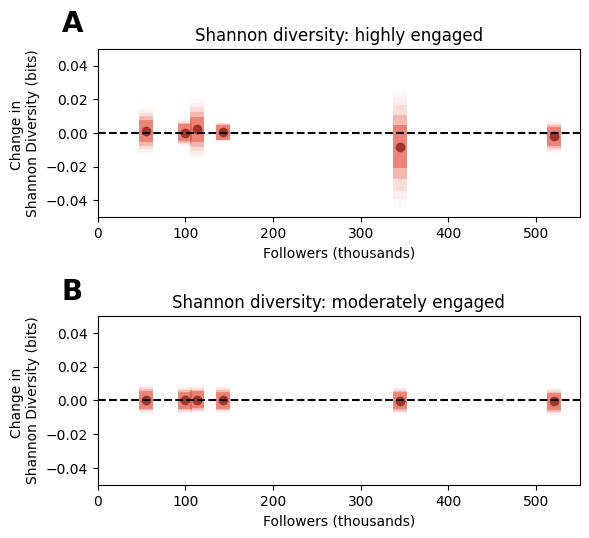

In [39]:
fig, axs = plt.subplots(2,1, figsize=(6,11/2))


plot_shannon(shannon_melted_top, shannon_fit_top,axs[0],ylim=.05)
plt.title('Shannon diversity: highly engaged')
plot_shannon(shannon_melted_median, shannon_fit_median,axs[1],ylim=.05)
plt.title('Shannon diversity: moderately engaged')

plt.tight_layout()

for n, ax in enumerate(axs):
    ax.text(-0.075, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
plt.tight_layout()
plt.savefig('./output/figures/fig3.png',dpi=300)
plt.savefig('./output/figures/fig3.pdf',dpi=300)